# Prisoner Cases

In this notebook we run regression models with the full dataframe of features to predict the number of COVID19 cases among prisoners
by State per month.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Features Selection</a></span><ul class="toc-item"><li><span><a href="#Nulls" data-toc-modified-id="Nulls-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nulls</a></span></li><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Custom-Train-Split" data-toc-modified-id="Custom-Train-Split-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Custom Train Split</a></span></li><li><span><a href="#Scale" data-toc-modified-id="Scale-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Scale</a></span></li></ul></li></ul></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Lasso" data-toc-modified-id="Lasso-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ridge</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Bagged-Decision-Tree" data-toc-modified-id="Bagged-Decision-Tree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bagged Decision Tree</a></span></li><li><span><a href="#K-Neighbors-Regressor" data-toc-modified-id="K-Neighbors-Regressor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>K Neighbors Regressor</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

In [226]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Features Selection

The dataset created in the previous notebook has to get trimmed and organized for different models we want to run. 

In [227]:
df = pd.read_csv('./data/data_clean_complete.csv')

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 44 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   name                                                510 non-null    object 
 1   state                                               510 non-null    object 
 2   staff_tests                                         340 non-null    float64
 3   total_staff_cases                                   510 non-null    float64
 4   staff_recovered                                     500 non-null    float64
 5   total_staff_deaths                                  510 non-null    float64
 6   prisoner_tests                                      500 non-null    float64
 7   total_prisoner_cases                                510 non-null    float64
 8   prisoners_recovered                                 500 non-null    float64
 9  

As mentioned, some of features present in the dataset are not useful for the problem or might result redundant. For this reason I proceed to drop them.

In [229]:
df.drop(columns=['state'], inplace= True)

In [230]:
df.isnull().sum()

name                                                    0
staff_tests                                           170
total_staff_cases                                       0
staff_recovered                                        10
total_staff_deaths                                      0
prisoner_tests                                         10
total_prisoner_cases                                    0
prisoners_recovered                                    10
total_prisoner_deaths                                   0
as_of_date                                              0
year                                                    0
month                                                   0
region                                                  0
civ_death                                               0
civ_cases                                               0
civ_hosp                                                0
civ_tests                                               0
Design capacit

Remove the federal record, keeping only States.

In [231]:
df.drop(df.loc[df['name']== 'Federal'].index, inplace=True)

In [232]:
df.isnull().sum()

name                                                    0
staff_tests                                           160
total_staff_cases                                       0
staff_recovered                                        10
total_staff_deaths                                      0
prisoner_tests                                         10
total_prisoner_cases                                    0
prisoners_recovered                                    10
total_prisoner_deaths                                   0
as_of_date                                              0
year                                                    0
month                                                   0
region                                                  0
civ_death                                               0
civ_cases                                               0
civ_hosp                                                0
civ_tests                                               0
Design capacit

### Nulls
Drop columns that still have nulls.

In [233]:
df.drop(columns=['staff_tests', 'staff_recovered', 'prisoner_tests', 'prisoners_recovered'], inplace= True)

### Categorical Features

State and Region are still objects and we want to transform them in binary features so that we can feed them into our regression models.

In [241]:
df = pd.get_dummies(data = df, columns= ['region', 'name'], drop_first=True)

In [242]:
df.drop(columns=['as_of_date'], inplace= True)

### Preprocessing

To begin modeling we realize some custom adjustment have to be made.

#### Custom Train Split

In particular, we decide to create our custo train and test split, using all data from March to December 2020 as a train and testing the models on January 2021 records.

This is achieved by srting the dataframe and filtering it per year.

*Note: this is possible because we have no overlap between months in 2020 and 2021.*

In [237]:
df.sort_values(by= ['month'], ascending=[True], inplace= True)

In [239]:
df.head()

,name,total_staff_cases,total_staff_deaths,total_prisoner_cases,total_prisoner_deaths,as_of_date,year,month,region,civ_death,...,Inmates participating in one or more work programs,Prison industries,Support services,Farming,Public works,Other work programs,No work programs,phone_rate_avg,Latitude,Longitude
509,Wyoming,10.0,0.0,23.0,0.0,2021-01-19,2021.0,1.0,West,158,...,1001.0,0.0,5.0,2.0,3.0,4.0,0.0,3.20,43.00,-107.500
139,Illinois,498.0,0.0,2645.0,19.0,2021-01-26,2021.0,1.0,Midwest,3275,...,29544.0,5.0,43.0,0.0,10.0,8.0,1.0,3.59,40.00,-89.250
129,Idaho,51.0,0.0,361.0,0.0,2021-01-26,2021.0,1.0,West,322,...,2286.0,4.0,12.0,0.0,6.0,4.0,1.0,2.30,44.07,-114.542
119,Hawaii,19.0,0.0,162.0,1.0,2021-01-26,2021.0,1.0,West,122,...,1718.0,3.0,7.0,3.0,5.0,1.0,2.0,3.36,20.79,-156.340
359,Ohio,643.0,1.0,446.0,5.0,2021-01-26,2021.0,1.0,Midwest,2213,...,34510.0,17.0,36.0,9.0,22.0,18.0,10.0,2.03,40.25,-83.000


In [244]:
df_train = df[df["year"] == 2020]
df_test = df[df["year"] == 2021]

In [246]:
df_train.shape

(450, 88)

In [283]:
X_train = df_train.drop(columns=['total_prisoner_cases', 'total_prisoner_deaths'])
X_test = df_test.drop(columns=['total_prisoner_cases', 'total_prisoner_deaths'])

y_train = df_train['total_prisoner_cases']
y_test = df_test['total_prisoner_cases']

#### Scale

Than we scale our Features sets.

In [286]:
X_train.shape, y_train.shape

((450, 86), (450,))

In [287]:
#Initiate standard scaler
ss = StandardScaler()

#finding the mean of standard deviation for each column
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Predict Number of cases of COVID 19 among Prisoners

## Linear Regression

In [288]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [289]:
# Step 2: Instantiate the model
lr = LinearRegression()

# Step 3: Fit the model
lr.fit(Xs_train, y_train)

LinearRegression()

In [290]:
y_preds = lr.predict(Xs_test)

In [291]:
metrics.mean_squared_error(y_test, y_preds)

1.0975281486062581e+30

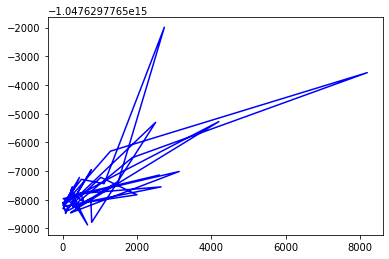

In [292]:
plt.plot(y_test, y_preds, color = 'blue');

In [293]:
lr.score(Xs_train,y_train), lr.score(Xs_test,y_test)

(0.818020964511634, -5.5355145420157543e+23)

Linear regression out of the box is performing poorly on our dataset.

### Lasso

We decide to run Lasso for its high interpretability and coefficent analysis.

In [294]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV

In [295]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(0.001, 100, 500)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas= l_alphas, cv = 50, max_iter= 5000)
# Fit model using best alpha
lasso_cv.fit(Xs_train, y_train)

# Here is the optimal value of alpha
lasso_cv.alpha_

63.76600051791755

In [296]:
print(lasso_cv.score(Xs_train, y_train)),
print(lasso_cv.score(Xs_test, y_test))

0.7610732346309405
0.6982595083790535


In [297]:
lasso = Lasso(lasso_cv.alpha_, max_iter= 5000, tol=0.001)

In [298]:
lasso.fit(Xs_train, y_train)

Lasso(alpha=63.76600051791755, max_iter=5000, tol=0.001)

In [299]:
lasso_score = cross_val_score(lasso, Xs_train, y_train, cv=10)

In [300]:
print(lasso_score)
print(np.mean(lasso_score))

[-1.8077575   0.36922094  0.57366335  0.84337222  0.56154981  0.80084235
  0.34788832  0.59491115  0.47207641  0.8550235 ]
0.3610790555527858


In [301]:
coefs = lasso.coef_

In [302]:
cf_list = [[list(sorted(zip(coefs, X_test.columns), reverse=True))]]
cf_list

[[[(1113.4732035260283, 'total_staff_cases'),
   (125.82586824592056, 'name_Michigan'),
   (50.03721751236157, 'name_Arkansas'),
   (2.2119335269411384, 'Farming '),
   (0.0, 'year'),
   (-0.0, 'total_staff_deaths'),
   (0.0, 'region_West'),
   (0.0, 'region_South'),
   (0.0, 'phone_rate_avg'),
   (-0.0, 'name_Wyoming'),
   (0.0, 'name_Wisconsin'),
   (-0.0, 'name_West Virginia'),
   (0.0, 'name_Washington'),
   (0.0, 'name_Virginia'),
   (-0.0, 'name_Vermont'),
   (0.0, 'name_Utah'),
   (0.0, 'name_Texas'),
   (0.0, 'name_Tennessee'),
   (0.0, 'name_South Dakota'),
   (-0.0, 'name_South Carolina'),
   (-0.0, 'name_Rhode Island'),
   (-0.0, 'name_Pennsylvania'),
   (-0.0, 'name_Oregon'),
   (0.0, 'name_Oklahoma'),
   (-0.0, 'name_Ohio'),
   (-0.0, 'name_North Dakota'),
   (-0.0, 'name_North Carolina'),
   (-0.0, 'name_New Mexico'),
   (-0.0, 'name_New Jersey'),
   (-0.0, 'name_New Hampshire'),
   (-0.0, 'name_Nevada'),
   (-0.0, 'name_Nebraska'),
   (-0.0, 'name_Montana'),
   (-0.0, 'n

Staff cases appears to have the highest weight in predicting the number of prisoners covid19 cases. Although we notice Farming as having an incredibly high value compared to other features.

### Ridge

Also we ran a Ridge model, cross validating it. We expect the results to be in the same range of performance as Lasso.

In [306]:
from sklearn.linear_model import Ridge, RidgeCV

In [307]:
r_alphas = np.logspace(0,5,100) #alphase from 1 to 10ˆ5

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas= r_alphas,
  scoring= 'r2',
  cv = 5)

In [308]:
ridge_cv.fit(Xs_train, y_train);

In [309]:
ridge_cv.alpha_# Here is the optimal value of alpha

533.6699231206308

In [310]:
#Now adding alpha in my model
# Instantiate.
ridge_model = Ridge(alpha = ridge_cv.alpha_)
# Fit.
ridge_model.fit(Xs_train, y_train)

Ridge(alpha=533.6699231206308)

In [312]:
print(ridge_model.score(Xs_train, y_train))
print(ridge_model.score(Xs_test, y_test))

0.6353589052546409
0.7508002032339519


The model appears to perform better on test data that on train, with a pretty significant variance.

## Random Forest

Random forest regressor is a model we believe can work well with our dataset. Even if it tends to overfit, the fact that many features values are replicated by state could improve the model ability to create meaningful splits, resulting in better predictions.

In [313]:
from sklearn.ensemble import RandomForestRegressor

In [314]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(Xs_train, y_train)

rf_pred = rf.predict(Xs_test) 
print(f'Score on training set: {rf.score(Xs_train, y_train)}')
print(f'Score on testing set: {rf.score(Xs_test, y_test)}')

Score on training set: 0.9124165969025751
Score on testing set: 0.7363445446706512


The out of the box model scores well but it is overfit.

To combat this we run a gridsearch.

In [319]:
rf_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto', 'log2']
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = 1, verbose = True)
gs_rf.fit(Xs_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.12833310846559304


{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [40]:
gs_rf_pred = gs_rf.predict(Xs_test)

In [320]:
rf_best = RandomForestRegressor(max_depth = 10,
 max_features = 'log2',
 min_samples_leaf = 2,
 min_samples_split = 2,
 n_estimators = 200, random_state= 1)

In [321]:
rf_best.fit(Xs_train, y_train)

rf_pred = rf_best.predict(Xs_test) 
print(f'Score on training set: {rf_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {rf_best.score(Xs_test, y_test)}')

Score on training set: 0.7184912174679712
Score on testing set: 0.7585878168961042


In [360]:
rmse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf

478648.6682709173

With the gridsearch we have significantly reduced the variance.

## Bagged Decision Tree

As per Random Forest, also bagged decision tree an perform well on our data in our expectations.

In [328]:
from sklearn.ensemble import BaggingRegressor

In [329]:
bg = BaggingRegressor()
bg.fit(Xs_train, y_train)

BaggingRegressor()

In [330]:
bg_pred = bg.predict(Xs_test) 
print(f'Score on training set: {bg.score(Xs_train, y_train)}')
print(f'Score on testing set: {bg.score(Xs_test, y_test)}')

Score on training set: 0.9089241643435625
Score on testing set: 0.4480433250212753


The out of the box model does great but we decide to run a gridsearch trying to combat overfit.

In [331]:
bag_params = {
    'n_estimators': [20, 25, 50],
    'max_samples': [0.5, 0.75, 0.9],
    'max_features': [0.5, 0.75, 0.9],
    'bootstrap_features': [True, False]
}
gs_bag = GridSearchCV(bg, param_grid=bag_params, cv=5, n_jobs = 1, verbose = True)
gs_bag.fit(Xs_train, y_train)
print(gs_bag.best_score_)
gs_bag.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.29001257980693185


{'bootstrap_features': True,
 'max_features': 0.75,
 'max_samples': 0.9,
 'n_estimators': 20}

In [333]:
bg_best = BaggingRegressor(bootstrap_features = True,
 max_features = 0.75,
 max_samples = 0.9,
 n_estimators = 20, random_state=1)

bg_best.fit(Xs_train, y_train);

In [334]:
bg_best_pred = bg_best.predict(Xs_test) 
print(f'Score on training set: {bg_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {bg_best.score(Xs_test, y_test)}')

Score on training set: 0.8211512473090699
Score on testing set: 0.6799943457561586


Good improvement but still oThe gridsearched model results having worse performances overall, but signifiantly improving the variance of 3 percentage points.verfit

## K Neighbors Regressor

Considering how lustered our data might appear by state, we decide to run a KNN Regressor.

In [336]:
from sklearn.neighbors import KNeighborsRegressor

In [349]:
knn = KNeighborsRegressor()

knn.fit(Xs_train, y_train)

print(f'Score on training set: {knn.score(Xs_train, y_train)}')
print(f'Score on testing set: {knn.score(Xs_test, y_test)}')

Score on training set: 0.5589812481019902
Score on testing set: 0.5173902049782084


The results on the out of the box model are lower than other models ran so far, but the variace is very low. We believe that having more months of data this model could really give reliable results.

In [346]:
knn_params = {
    'n_neighbors': (7, 9, 12),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights' : ['uniform', 'distance']
}

# Instantiate our GridSearchCV object.
knn_gs = GridSearchCV(knn, 
                              knn_params, 
                              cv = 10, 
                              verbose=1)
                              
# Fit the GridSearchCV object to the data
knn_gs.fit(Xs_train, y_train)
# Print out the set of hyperparameters that achieved the best score.
knn_gs.best_params_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [347]:
knn_best = KNeighborsRegressor(metric = 'manhattan',
                         n_neighbors = 7,
                         weights= 'distance')

knn_best.fit(Xs_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance')

In [350]:
knn_pred = knn_best.predict(Xs_test) 
print(f'Score on training set: {knn_best.score(Xs_train, y_train)}')
print(f'Score on testing set: {knn_best.score(Xs_test, y_test)}')

Score on training set: 1.0
Score on testing set: 0.6422219995285317


We did run a gridsearch, but it seemed to optimize the results on train decreasing heavily the performance on test data.

## Results

Below we collect all results for the models ran in this notebook.

In [358]:

print(f'COVID-19 Cases Prisoners')
print(f' ')
print(f'Lasso')
print(f'Train R2:{round(lasso_cv.score(Xs_train, y_train), 3)}'),
print(f'Score on test set:{round(lasso_cv.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Ridge')
print(f'Train R2: {round(ridge_model.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(ridge_model.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Random Forest')
print(f'Train R2: {round(rf_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(rf_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'Bagged Decision Tree')
print(f'Score on training set: {round(bg_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(bg_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'K Neighbors Regressor - Gridsearch')
print(f'Score on training set: {round(knn_best.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(knn_best.score(Xs_test, y_test), 3)}')
print(f' ')
print(f'K Neighbors Regressor - Out of the box')
print(f'Score on training set: {round(knn.score(Xs_train, y_train), 3)}')
print(f'Score on testing set: {round(knn.score(Xs_test, y_test), 3)}')

COVID-19 Cases Prisoners
 
Lasso
Score on training set:0.761
Score on test set:0.698
 
Ridge
Score on training set: 0.635
Score on testing set: 0.751
 
Random Forest
Score on training set: 0.718
Score on testing set: 0.759
 
Bagged Decision Tree
Score on training set: 0.821
Score on testing set: 0.68
 
K Neighbors Regressor - Gridsearch
Score on training set: 1.0
Score on testing set: 0.642
 
K Neighbors Regressor - Out of the box
Score on training set: 0.559
Score on testing set: 0.517


Random Forest appears as the model capable of achieving the best results while also minimizing variance.